In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchsummary import summary

In [ ]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])
    
    
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz ,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader



In [ ]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, test_loader=mnist(batch_sz) 

In [ ]:
#Q1: Plot all the images of a training batch in a grid and verfiy that they are transformed.
tl = iter(train_loader)
batch = next(tl)

for i in range(batch_sz):
  plt.subplot(8,8, i+1)
  plt.imshow(batch[0][i,:,:,:].squeeze())
  plt.axis("off")



In [ ]:
# Q2: Plot all the images of a test batch in a grid and verfiy that they are NOT tranformed.

tl2 = iter(test_loader)
batch = next(tl)

for i in range(batch_sz):
  plt.subplot(8,8, i+1)
  plt.imshow(batch[0][i,:,:,:].squeeze())
  plt.axis("off")


In [23]:
# Q3 NN: define a 2 layer simple NN for mnist digit classificaiton

class NN(nn.Module):
    def __init__(self, input_size=784, output_classes=10) -> None:
        super(NN, self).__init__()
        self._layer_in = nn.Linear(input_size, 100)
        self._layer_hidden = nn.Linear(100, 100)
        self._layer_out = nn.Linear(100, output_classes)

    def forward(self, x):
        x = F.sigmoid(self._layer_in(x))
        x = F.sigmoid(self._layer_hidden(x))
        x = self._layer_out(x)

        return x




In [24]:
# Device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# Hyperparameter

input_size = 784
output_classes = 10
lr = 0.01
batch_size = 64
epoch = 10
momentum = 0.5

# Initialize

model = NN(input_size=input_size, output_classes=output_classes).to(device)



# Loss and Optimization

loss_function = nn.CrossEntropyLoss()
opti = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


In [29]:
# Train the model
loss_l = []


for i in range(epoch):
    loss_counter=0



    for batch in train_loader:
        X = batch[0]
        y = batch[1]

        X = X.reshape(X.shape[0], -1)

        X.to(device=device)
        y.to(device=device)

        logits = model(X)
        loss = loss_function(logits, y)

        print(loss)

        # loss_counter += loss.items()

        loss_l.append(loss.detach().numpy())
        
        opti.zero_grad()
        loss.backward()

        opti.step()

    loss_l.append(loss_counter)

        # print(loss)
        # print(logits)

        # hvalues = np.argmax(logits.detach().numpy())

        # acc = sum(hvalues == Y.detach().numpy())

        # acc_l.append(acc/batch_sz)



        # loss_l.append(loss.detach().numpy())

device = torch.device('cuda')




tensor(1.4142, grad_fn=<NllLossBackward0>)
tensor(1.2774, grad_fn=<NllLossBackward0>)
tensor(1.5673, grad_fn=<NllLossBackward0>)
tensor(1.4529, grad_fn=<NllLossBackward0>)
tensor(1.2822, grad_fn=<NllLossBackward0>)
tensor(1.1803, grad_fn=<NllLossBackward0>)
tensor(1.2898, grad_fn=<NllLossBackward0>)
tensor(1.3926, grad_fn=<NllLossBackward0>)
tensor(1.4691, grad_fn=<NllLossBackward0>)
tensor(1.4259, grad_fn=<NllLossBackward0>)
tensor(1.3797, grad_fn=<NllLossBackward0>)
tensor(1.3114, grad_fn=<NllLossBackward0>)
tensor(1.4099, grad_fn=<NllLossBackward0>)
tensor(1.5266, grad_fn=<NllLossBackward0>)
tensor(1.6868, grad_fn=<NllLossBackward0>)
tensor(1.3888, grad_fn=<NllLossBackward0>)
tensor(1.5200, grad_fn=<NllLossBackward0>)
tensor(1.4710, grad_fn=<NllLossBackward0>)
tensor(1.3877, grad_fn=<NllLossBackward0>)
tensor(1.4999, grad_fn=<NllLossBackward0>)
tensor(1.4266, grad_fn=<NllLossBackward0>)
tensor(1.3399, grad_fn=<NllLossBackward0>)
tensor(1.5766, grad_fn=<NllLossBackward0>)
tensor(1.48

KeyboardInterrupt: 

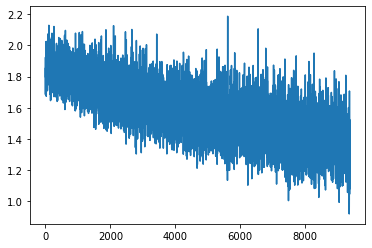

In [27]:
#Q4: Train the NN for 10 epochs and plot the loss and accuracy 

plt.figure()

plt.plot(loss_l)


In [ ]:
#Q5: Save the NN and load it with a new name verify that the 
#correct weights are loaded by comparing the bias terms of the last layer

torch.safe(NN.state.dict(), "My Model")

loaded_model = NN(784,10)
loaded_model.load_state_dict(torch.load("My Model"))

In [ ]:
#Q6: For the incorrectly labelled images collect all the images, 
#true label and predicted label in three lists. 

device = torch.device('cpu')

image = []
true_label = []
wrong_label = []
for batch in test_loader:
    X = batch[0].to(device)
    Y = batch[1].to(device)

    logits = model(X)

    label = torch.argmax(logits, axis=1)
    for i in range(X.shape[0]):
        if label[i] != y[i]:
            image.append(X[i,0,:,:])
            true_label.append(y[i])
            wrong_label.append(label[i])

In [ ]:
#Q7: Plot the first 10 incorrectly labeled images, 
#their true and predicted label should be in title of the plot.

for l in range(10):
    plt.imshow(image[l])
    plt.show()
    print("Ture Label = ",true_label[l].item())
    print("Ture Label = ",true_label[l].item())